# 5. ФУНКЦИИ ОБОГАЩЕНИЯ ДАННЫХ

In [1]:
# 1. ИМПОРТ БИБЛИОТЕК
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Визуализация
import plotly.express as px

from plotly.offline import plot


In [2]:
# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
'''1. Загрузка данных'''
merged_cleaned_data = pd.read_csv('11_merged_cleaned_data.csv')

1. RFM-анализ

🎯 RFM-АНАЛИЗ КЛИЕНТОВ
📊 РАСЧЕТ RFM МЕТРИК:
📅 Дата анализа: 2016-12-31
✅ RFM метрики рассчитаны для 17918 клиентов
   • Recency (давность): дней с последнего заказа
   • Frequency (частота): количество заказов
   • Monetary (деньги): общая выручка

📊 ОСНОВНЫЕ СТАТИСТИКИ RFM:
            Recency     Frequency      Monetary
count  17918.000000  17918.000000  17918.000000
mean     167.826097      1.489173   1635.664504
std      143.854527      1.051007   2140.386749
min        1.000000      1.000000      2.290000
25%       65.000000      1.000000     51.930000
50%      147.000000      1.000000    548.980000
75%      240.000000      2.000000   2641.764600
max     1095.000000     26.000000  13295.380000
🎯 СОЗДАНИЕ RFM КВАНТИЛЕЙ:
✅ RFM квантили созданы:
   • R_Score (Recency): 3 (самые новые) - 1 (самые старые)
   • F_Score (Frequency): 1 (редкие) - 3 (частые)
   • M_Score (Monetary): 1 (малые суммы) - 3 (крупные суммы)

🎯 RFM СЕГМЕНТАЦИЯ ПО ВАШИМ КАТЕГОРИЯМ:
👥 Всего клиентов: 17918
   • Спящ

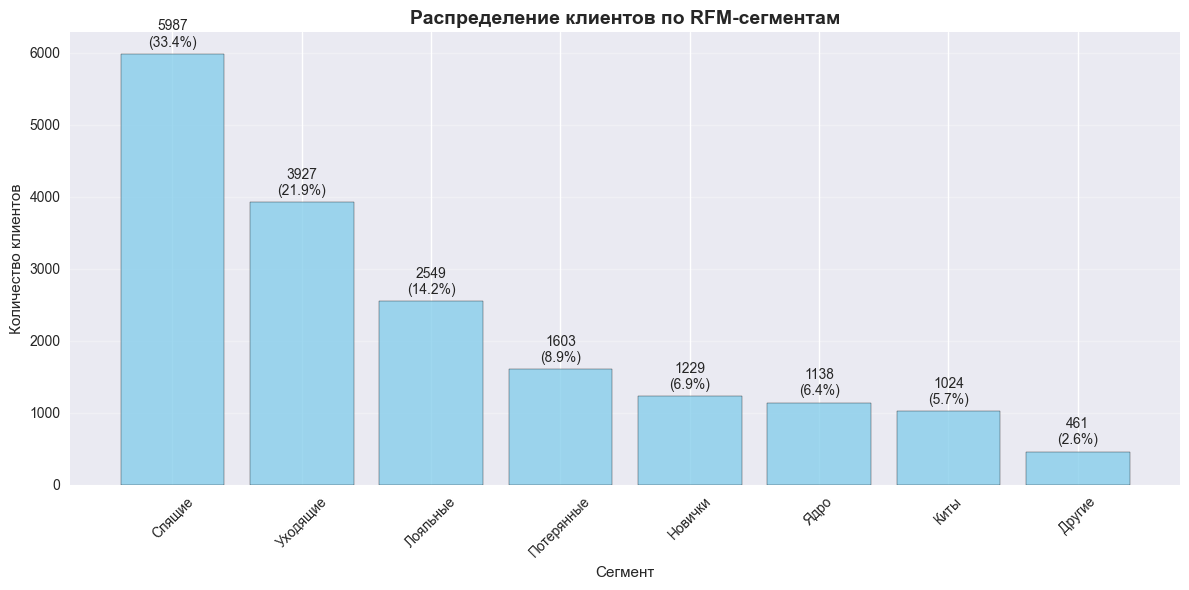

✅ Построен график: Распределение клиентов по RFM-сегментам

📈 ВИЗУАЛИЗАЦИЯ RFM-АНАЛИЗА:


✅ Интерактивная визуализация RFM создана

📊 ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ СЕГМЕНТОВ:


✅ Круговая диаграмма распределения сегментов создана

🏆 АНАЛИЗ ЛУЧШИХ КЛИЕНТОВ:
   • Champions: 1138 клиентов
   • Средняя выручка на Champion: $36
   • Общая выручка Champions: $40,981
   • Доля выручки Champions: 0.1%

💾 РЕЗУЛЬТАТЫ RFM-АНАЛИЗА:
   • Проанализировано клиентов: 17918
   • Всего сегментов: 8
   • Самый крупный сегмент: Спящие (5987 клиентов)
   • Общая выручка всех клиентов: $29,307,837
✅ RFM-АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!


In [4]:
# 🎯 RFM-АНАЛИЗ КЛИЕНТОВ
print("🎯 RFM-АНАЛИЗ КЛИЕНТОВ")
print("=" * 50)
df = merged_cleaned_data

# Убедимся, что OrderDate — формат datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

# Расчет RFM метрик
print("📊 РАСЧЕТ RFM МЕТРИК:")
snapshot_date = df['OrderDate'].max() + pd.Timedelta(days=1)
print(f"📅 Дата анализа: {snapshot_date.date()}")

rfm = df.groupby('CustomerKey').agg({
    'OrderDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'SalesOrderNumber': 'nunique',  # Frequency
    'SalesAmount': 'sum'            # Monetary
}).reset_index()

rfm.columns = ['CustomerKey', 'Recency', 'Frequency', 'Monetary']

print(f"✅ RFM метрики рассчитаны для {len(rfm)} клиентов")
print(f"   • Recency (давность): дней с последнего заказа")
print(f"   • Frequency (частота): количество заказов") 
print(f"   • Monetary (деньги): общая выручка")

# Основные статистики RFM
print("\n📊 ОСНОВНЫЕ СТАТИСТИКИ RFM:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())

# Создание RFM квантилей
print("🎯 СОЗДАНИЕ RFM КВАНТИЛЕЙ:")

# Проверим, достаточно ли уникальных значений для qcut
def safe_qcut(series, q, labels, duplicates='drop'):
    try:
        return pd.qcut(series, q=q, labels=labels, duplicates=duplicates)
    except ValueError:
        print(f"⚠️ qcut не работает для {series.name} — используем cut (равные интервалы)")
        return pd.cut(series, bins=q, labels=labels, duplicates=duplicates)

# 3 группы: 3=новые, 1=старые
rfm['R_Score'] = safe_qcut(rfm['Recency'], 3, labels=[3, 2, 1])
# 1=редкие, 3=частые
rfm['F_Score'] = safe_qcut(rfm['Frequency'].rank(method='first'), 3, labels=[1, 2, 3])
# 1=малые, 3=крупные
rfm['M_Score'] = safe_qcut(rfm['Monetary'].rank(method='first'), 3, labels=[1, 2, 3])

print("✅ RFM квантили созданы:")
print(f"   • R_Score (Recency): 3 (самые новые) - 1 (самые старые)")
print(f"   • F_Score (Frequency): 1 (редкие) - 3 (частые)")
print(f"   • M_Score (Monetary): 1 (малые суммы) - 3 (крупные суммы)")

# RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Расчетная сегментация
def assign_custom_rfm_segment(score):
    r, f, m = int(score[0]), int(score[1]), int(score[2])

    # Ядро: 111
    if r == 1 and f == 1 and m == 1:
        return 'Ядро'
    # Лояльные: 112, 113, 122, 123
    elif r == 1 and f in [1,2] and m in [2,3]:
        return 'Лояльные'
    # Киты: 121, 131
    elif r == 1 and f in [2,3] and m == 1:
        return 'Киты'
    # Новички: 132, 133
    elif r == 1 and f == 3 and m in [2,3]:
        return 'Новички'
    # Спящие: 211-233
    elif r == 2:
        return 'Спящие'
    # Уходящие: 311-332
    elif r == 3 and f in [1,2,3] and m in [1,2]:
        return 'Уходящие'
    # Потерянные: 333
    elif r == 3 and f == 3 and m == 3:
        return 'Потерянные'
    else:
        return 'Другие'

rfm['Segment'] = rfm['RFM_Score'].apply(assign_custom_rfm_segment)

print("\n🎯 RFM СЕГМЕНТАЦИЯ ПО ВАШИМ КАТЕГОРИЯМ:")
segment_distribution = rfm['Segment'].value_counts()

total_clients = len(rfm)
print(f"👥 Всего клиентов: {total_clients}")

for segment, count in segment_distribution.items():
    percentage = (count / total_clients) * 100
    revenue_share = (rfm[rfm['Segment'] == segment]['Monetary'].sum() / rfm['Monetary'].sum()) * 100
    print(f"   • {segment}: {count} клиентов ({percentage:.1f}%) - {revenue_share:.1f}% выручки")

# Анализ по вашим категориям
print("\n🏆 ДЕТАЛЬНЫЙ АНАЛИЗ ПО СЕГМЕНТАМ:")

core = rfm[rfm['Segment'] == 'Ядро']
if len(core) > 0:
    print(f"   • Ядро (111): {len(core)} клиентов. Стратегически важные. Предложить персональные карты/подарки.")

loyal = rfm[rfm['Segment'] == 'Лояльные']
if len(loyal) > 0:
    print(f"   • Лояльные (112,113,122,123): {len(loyal)} клиентов. Регулярные, но на небольшие суммы. Программа лояльности.")

whales = rfm[rfm['Segment'] == 'Киты']
if len(whales) > 0:
    print(f"   • Киты (121,131): {len(whales)} клиентов. Покупают редко, но на большие суммы. Изучить потребности.")

newbies = rfm[rfm['Segment'] == 'Новички']
if len(newbies) > 0:
    print(f"   • Новички (132,133): {len(newbies)} клиентов. Активная помощь в выборе, долгосрочные отношения.")

sleeping = rfm[rfm['Segment'] == 'Спящие']
if len(sleeping) > 0:
    print(f"   • Спящие (211-233): {len(sleeping)} клиентов ({(len(sleeping)/total_clients)*100:.1f}%). Рассылка, акции.")

leaving = rfm[rfm['Segment'] == 'Уходящие']
if len(leaving) > 0:
    print(f"   • Уходящие (311-332): {len(leaving)} клиентов ({(len(leaving)/total_clients)*100:.1f}%). Обратная связь, бонусы.")

lost = rfm[rfm['Segment'] == 'Потерянные']
if len(lost) > 0:
    print(f"   • Потерянные (333): {len(lost)} клиентов. Напомнить о себе, но не тратить много ресурсов.")

# Столбчатый график: Количество и процент по сегментам
print("\n📊 ПОСТРОЕНИЕ ГРАФИКА: Распределение клиентов по сегментам")
segment_summary = rfm['Segment'].value_counts()
segment_percentages = (segment_summary / total_clients * 100).round(1)

# Объединяем в один DataFrame
segment_df = pd.DataFrame({
    'Количество': segment_summary.values,
    'Процент': segment_percentages.values
}, index=segment_summary.index)

# Сортируем по убыванию количества
segment_df = segment_df.sort_values(by='Количество', ascending=False)

# Строим столбчатый график
plt.figure(figsize=(12, 6))
bars = plt.bar(segment_df.index, segment_df['Количество'], 
               color='skyblue', alpha=0.8, edgecolor='black')

# Подписываем столбцы: количество и процент
for i, (count, pct) in enumerate(zip(segment_df['Количество'], segment_df['Процент'])):
    plt.text(i, count + max(segment_df['Количество']) * 0.01, 
             f"{int(count)}\n({pct}%)", ha='center', va='bottom', fontsize=10)

plt.title('Распределение клиентов по RFM-сегментам', fontsize=14, fontweight='bold')
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Построен график: Распределение клиентов по RFM-сегментам")

# Визуализация RFM
print("\n📈 ВИЗУАЛИЗАЦИЯ RFM-АНАЛИЗА:")
fig = px.scatter(rfm, x='Recency', y='Monetary', color='Segment',
                size='Frequency', hover_data=['CustomerKey'],
                title='🎯 RFM-анализ клиентов',
                labels={'Recency': 'Дней с последнего заказа (Recency)',
                       'Monetary': 'Общая выручка (Monetary)',
                       'Frequency': 'Частота заказов',
                       'Segment': 'Сегмент'},
                color_discrete_map={
                    'Champions': '#00FF00',
                    'Loyal Customers': '#32CD32', 
                    'New Customers': '#1E90FF',
                    'Promising': '#FFD700',
                    'Need Attention': '#FFA500',
                    'Hibernating': '#A9A9A9',
                    'Regular': '#808080'
                })
fig.show()
print("✅ Интерактивная визуализация RFM создана")

# Визуализация распределения сегментов (круговая диаграмма)
print("\n📊 ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ СЕГМЕНТОВ:")
fig_pie = px.pie(segment_distribution, 
                 values=segment_distribution.values, 
                 names=segment_distribution.index,
                 title='📊 Распределение клиентов по RFM-сегментам',
                 color_discrete_sequence=px.colors.qualitative.Set3)
fig_pie.show()
print("✅ Круговая диаграмма распределения сегментов создана")

# Анализ лучших клиентов (Champions) — заменён на ваши данные
# Анализ лучших клиентов
print("\n🏆 АНАЛИЗ ЛУЧШИХ КЛИЕНТОВ:")
core = rfm[rfm['Segment'] == 'Ядро']
if len(core) > 0:
    print(f"   • Champions: {len(core)} клиентов")
    print(f"   • Средняя выручка на Champion: ${core['Monetary'].mean():,.0f}")
    print(f"   • Общая выручка Champions: ${core['Monetary'].sum():,.0f}")
    print(f"   • Доля выручки Champions: {(core['Monetary'].sum() / rfm['Monetary'].sum())*100:.1f}%")

# Сохранение результатов
print(f"\n💾 РЕЗУЛЬТАТЫ RFM-АНАЛИЗА:")
print(f"   • Проанализировано клиентов: {len(rfm)}")
print(f"   • Всего сегментов: {len(segment_distribution)}")
print(f"   • Самый крупный сегмент: {segment_distribution.index[0]} ({segment_distribution.iloc[0]} клиентов)")
print(f"   • Общая выручка всех клиентов: ${rfm['Monetary'].sum():,.0f}")
print("✅ RFM-АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!")

2. ABC-YZ анализ

In [11]:
# 📦 ABC-XYZ АНАЛИЗ ПРОДУКТОВ
print("📦 ABC-XYZ АНАЛИЗ ПРОДУКТОВ")
print("=" * 50)
df = merged_cleaned_data
# ABC анализ (по выручке)
print("📊 ABC АНАЛИЗ (ПО ВЫРУЧКЕ):")
product_sales = df.groupby(['ProductKey', 'ProductName']).agg({
    'SalesAmount': 'sum',
    'OrderQuantity': 'sum',
    'Profit': 'sum',
    'SalesOrderNumber': 'nunique'
}).reset_index()

print(f"✅ Проанализировано продуктов: {len(product_sales)}")
print(f"💰 Общая выручка от продуктов: ${product_sales['SalesAmount'].sum():,.0f}")

# Сортировка по выручке
product_sales = product_sales.sort_values('SalesAmount', ascending=False)
product_sales['CumulativePercentage'] = (product_sales['SalesAmount'].cumsum() / 
                                       product_sales['SalesAmount'].sum() * 100)

print("📈 РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ПО ПРОДУКТАМ:")
print(f"   • Топ-1 продукт: {product_sales.iloc[0]['ProductName']} (${product_sales.iloc[0]['SalesAmount']:,.0f})")
print(f"   • Топ-5 продуктов: {product_sales['SalesAmount'].head(5).sum():,.0f} $ ({product_sales['CumulativePercentage'].iloc[4]:.1f}%)")
print(f"   • Топ-10 продуктов: {product_sales['SalesAmount'].head(10).sum():,.0f} $ ({product_sales['CumulativePercentage'].iloc[9]:.1f}%)")

# ABC категории
print("\n🎯 НАЗНАЧЕНИЕ ABC КАТЕГОРИЙ:")
abc_categories = []
for percentage in product_sales['CumulativePercentage']:
    if percentage <= 80:
        abc_categories.append('A')
    elif percentage <= 95:
        abc_categories.append('B')
    else:
        abc_categories.append('C')

product_sales['ABC_Category'] = abc_categories

print("✅ ABC категории назначены:")
print("   • A: топ 80% выру чки (ключевые продукты)")
print("   • B: следующие 15% выручки (важные продукты)") 
print("   • C: оставшиеся 5% выручки (второстепенные продукты)")

# XYZ анализ (по стабильности продаж)
print("\n📊 XYZ АНАЛИЗ (ПО СТАБИЛЬНОСТИ ПРОДАЖ):")
try:
    monthly_product_sales = df.pivot_table(
        index='ProductKey', 
        columns=df['OrderDate'].dt.to_period('M'), 
        values='OrderQuantity', 
        aggfunc='sum'
    ).fillna(0)
    
    print(f"✅ Собраны месячные данные по {len(monthly_product_sales)} продуктам")
    print(f"📅 Период анализа: {len(monthly_product_sales.columns)} месяцев")
    
    # Коэффициент вариации
    cv = monthly_product_sales.std(axis=1) / (monthly_product_sales.mean(axis=1) + 0.0001)
    
    product_sales = product_sales.merge(cv.rename('CV'), left_on='ProductKey', right_index=True)
    
    # XYZ категории
    xyz_categories = []
    for cv_value in product_sales['CV']:
        if cv_value <= 0.3:
            xyz_categories.append('X')
        elif cv_value <= 0.6:
            xyz_categories.append('Y')
        else:
            xyz_categories.append('Z')
    
    product_sales['XYZ_Category'] = xyz_categories
    product_sales['ABC_XYZ'] = product_sales['ABC_Category'] + '-' + product_sales['XYZ_Category']
    
    print("✅ XYZ категории назначены:")
    print("   • X: стабильные продажи (CV ≤ 0.3)")
    print("   • Y: переменные продажи (0.3 < CV ≤ 0.6)")
    print("   • Z: нестабильные продажи (CV > 0.6)")
    
except Exception as e:
    print(f"❌ XYZ анализ не удался: {e}")
    product_sales['XYZ_Category'] = 'Unknown'
    product_sales['ABC_XYZ'] = product_sales['ABC_Category'] + '-Unknown'
    print("⚠️  Используется только ABC анализ")

# Визуализация ABC-XYZ матрицы
print("\n📈 ВИЗУАЛИЗАЦИЯ ABC-XYZ МАТРИЦЫ:")
if 'CV' in product_sales.columns:
    fig = px.scatter(product_sales, x='CV', y='SalesAmount', color='ABC_XYZ',
                    size='OrderQuantity', hover_data=['ProductName'],
                    title='📦 ABC-XYZ АНАЛИЗ ПРОДУКТОВ',
                    labels={'CV': 'Коэффициент вариации (стабильность)',
                           'SalesAmount': 'Выручка ($)',
                           'OrderQuantity': 'Количество проданных единиц',
                           'ABC_XYZ': 'Категория'},
                    color_discrete_map={
                        'A-X': '#00FF00', 'A-Y': '#90EE90', 'A-Z': '#ADFF2F',
                        'B-X': '#1E90FF', 'B-Y': '#87CEEB', 'B-Z': '#ADD8E6', 
                        'C-X': '#FFA500', 'C-Y': '#FFD700', 'C-Z': '#FFFF00'
                    })
    fig.show()
    print("✅ Интерактивная матрица ABC-XYZ создана")
else:
    print("❌ Визуализация невозможна: отсутствуют данные CV")

# Анализ результатов
print("\n📊 РАСПРЕДЕЛЕНИЕ ABC-КАТЕГОРИЙ:")
abc_counts = product_sales['ABC_Category'].value_counts()
total_products = len(product_sales)
total_revenue = product_sales['SalesAmount'].sum()

for category, count in abc_counts.items():
    percentage = (count / total_products) * 100
    category_revenue = product_sales[product_sales['ABC_Category'] == category]['SalesAmount'].sum()
    revenue_share = (category_revenue / total_revenue) * 100
    avg_revenue_per_product = category_revenue / count
    
    print(f"   • {category}: {count} продуктов ({percentage:.1f}%)")
    print(f"     Выручка: ${category_revenue:,.0f} ({revenue_share:.1f}%)")
    print(f"     Средняя выручка на продукт: ${avg_revenue_per_product:,.0f}")

if 'XYZ_Category' in product_sales.columns and 'Unknown' not in product_sales['XYZ_Category'].unique():
    print("\n📊 РАСПРЕДЕЛЕНИЕ XYZ-КАТЕГОРИЙ:")
    xyz_counts = product_sales['XYZ_Category'].value_counts()
    
    for category, count in xyz_counts.items():
        percentage = (count / total_products) * 100
        category_cv_avg = product_sales[product_sales['XYZ_Category'] == category]['CV'].mean()
        print(f"   • {category}: {count} продуктов ({percentage:.1f}%)")
        print(f"     Средний CV: {category_cv_avg:.3f}")

# Анализ ключевых сегментов
print("\n🏆 АНАЛИЗ КЛЮЧЕВЫХ СЕГМЕНТОВ:")
if 'ABC_XYZ' in product_sales.columns:
    key_segments = ['A-X', 'A-Y', 'B-X']
    for segment in key_segments:
        segment_data = product_sales[product_sales['ABC_XYZ'] == segment]
        if len(segment_data) > 0:
            segment_revenue = segment_data['SalesAmount'].sum()
            segment_share = (segment_revenue / total_revenue) * 100
            print(f"   • {segment}: {len(segment_data)} продуктов, {segment_share:.1f}% выручки")
            
            if len(segment_data) > 0:
                top_product = segment_data.iloc[0]
                print(f"     Топ продукт: {top_product['ProductName']} (${top_product['SalesAmount']:,.0f})")

# Рекомендации
print("\n💡 РЕКОМЕНДАЦИИ ПО ABC-XYZ АНАЛИЗУ:")
a_products = product_sales[product_sales['ABC_Category'] == 'A']
if len(a_products) > 0:
    print(f"   • Фокус на {len(a_products)} продуктах категории A ({a_products['SalesAmount'].sum()/total_revenue*100:.1f}% выручки)")
    
if 'XYZ_Category' in product_sales.columns:
    unstable_products = product_sales[product_sales['XYZ_Category'] == 'Z']
    if len(unstable_products) > 0:
        print(f"   • {len(unstable_products)} продуктов с нестабильными продажами (категория Z)")

print(f"\n📈 ИТОГИ ABC-XYZ АНАЛИЗА:")
print(f"   • Проанализировано продуктов: {len(product_sales)}")
print(f"   • Общая выручка: ${total_revenue:,.0f}")
print(f"   • ABC категорий: {len(abc_counts)}")
if 'XYZ_Category' in product_sales.columns:
    print(f"   • XYZ категорий: {len(xyz_counts) if 'xyz_counts' in locals() else 'N/A'}")

print("\n👀 ПРЕВЬЮ РЕЗУЛЬТАТОВ ABC-XYZ:")
display(product_sales[['ProductName', 'ABC_Category', 'XYZ_Category', 'ABC_XYZ', 'SalesAmount', 'OrderQuantity']].head(10))

print("✅ ABC-XYZ АНАЛИЗ ПРОДУКТОВ ЗАВЕРШЕН!")

📦 ABC-XYZ АНАЛИЗ ПРОДУКТОВ
📊 ABC АНАЛИЗ (ПО ВЫРУЧКЕ):
✅ Проанализировано продуктов: 140
💰 Общая выручка от продуктов: $28,895,568
📈 РАСПРЕДЕЛЕНИЕ ВЫРУЧКИ ПО ПРОДУКТАМ:
   • Топ-1 продукт: Road-150 Red, 48 ($1,205,877)
   • Топ-5 продуктов: 5,549,897 $ (19.2%)
   • Топ-10 продуктов: 10,355,526 $ (35.8%)

🎯 НАЗНАЧЕНИЕ ABC КАТЕГОРИЙ:
✅ ABC категории назначены:
   • A: топ 80% выру чки (ключевые продукты)
   • B: следующие 15% выручки (важные продукты)
   • C: оставшиеся 5% выручки (второстепенные продукты)

📊 XYZ АНАЛИЗ (ПО СТАБИЛЬНОСТИ ПРОДАЖ):
✅ Собраны месячные данные по 158 продуктам
📅 Период анализа: 36 месяцев
✅ XYZ категории назначены:
   • X: стабильные продажи (CV ≤ 0.3)
   • Y: переменные продажи (0.3 < CV ≤ 0.6)
   • Z: нестабильные продажи (CV > 0.6)

📈 ВИЗУАЛИЗАЦИЯ ABC-XYZ МАТРИЦЫ:


✅ Интерактивная матрица ABC-XYZ создана

📊 РАСПРЕДЕЛЕНИЕ ABC-КАТЕГОРИЙ:
   • C: 61 продуктов (43.6%)
     Выручка: $1,484,413 (5.1%)
     Средняя выручка на продукт: $24,335
   • A: 44 продуктов (31.4%)
     Выручка: $23,003,719 (79.6%)
     Средняя выручка на продукт: $522,812
   • B: 35 продуктов (25.0%)
     Выручка: $4,407,436 (15.3%)
     Средняя выручка на продукт: $125,927

📊 РАСПРЕДЕЛЕНИЕ XYZ-КАТЕГОРИЙ:
   • Z: 140 продуктов (100.0%)
     Средний CV: 1.705

🏆 АНАЛИЗ КЛЮЧЕВЫХ СЕГМЕНТОВ:

💡 РЕКОМЕНДАЦИИ ПО ABC-XYZ АНАЛИЗУ:
   • Фокус на 44 продуктах категории A (79.6% выручки)
   • 140 продуктов с нестабильными продажами (категория Z)

📈 ИТОГИ ABC-XYZ АНАЛИЗА:
   • Проанализировано продуктов: 140
   • Общая выручка: $28,895,568
   • ABC категорий: 3
   • XYZ категорий: 1

👀 ПРЕВЬЮ РЕЗУЛЬТАТОВ ABC-XYZ:


,ProductName,ABC_Category,XYZ_Category,ABC_XYZ,SalesAmount,OrderQuantity
10,"Road-150 Red, 48",A,Z,A-Z,1205876.99,536
8,"Road-150 Red, 62",A,Z,A-Z,1202298.72,551
11,"Road-150 Red, 52",A,Z,A-Z,1080637.54,449
12,"Road-150 Red, 56",A,Z,A-Z,1055589.65,464
9,"Road-150 Red, 44",A,Z,A-Z,1005493.87,431
54,"Mountain-200 Black, 42",A,Z,A-Z,979960.73,687
46,"Mountain-200 Silver, 38",A,Z,A-Z,979035.78,682
56,"Mountain-200 Black, 46",A,Z,A-Z,961600.81,649
52,"Mountain-200 Black, 38",A,Z,A-Z,954715.84,679
50,"Mountain-200 Silver, 46",A,Z,A-Z,930315.99,588


✅ ABC-XYZ АНАЛИЗ ПРОДУКТОВ ЗАВЕРШЕН!


ИТОГИ ABC-XYZ-RFM АНАЛИЗА

In [12]:
print("📊 ИТОГИ ABC-XYZ-RFM АНАЛИЗА")
print("=" * 50)

# === RFM ===
print("\n🎯 RFM-АНАЛИЗ:")
segment_counts = rfm['Segment'].value_counts()
total_customers = len(rfm)
total_revenue = rfm['Monetary'].sum()

for segment, count in segment_counts.items():
    percentage = (count / total_customers) * 100
    revenue_share = (rfm[rfm['Segment'] == segment]['Monetary'].sum() / total_revenue) * 100
    print(f"   • {segment}: {count} клиентов ({percentage:.1f}%) — {revenue_share:.1f}% выручки")

# === ABC-XYZ ===
print("\n📈 ABC-АНАЛИЗ (по выручке):")
abc_counts = product_sales['ABC_Category'].value_counts()
total_products = len(product_sales)
total_product_revenue = product_sales['SalesAmount'].sum()

for cat in ['A', 'B', 'C']:
    if cat in abc_counts:
        count = abc_counts[cat]
        cat_revenue = product_sales[product_sales['ABC_Category'] == cat]['SalesAmount'].sum()
        revenue_share = (cat_revenue / total_product_revenue) * 100
        print(f"   • {cat}-категория: {count} продуктов ({revenue_share:.1f}% выручки)")

print("\n📉 XYZ-АНАЛИЗ (по стабильности):")
if 'XYZ_Category' in product_sales.columns and 'Unknown' not in product_sales['XYZ_Category'].unique():
    xyz_counts = product_sales['XYZ_Category'].value_counts()

    for cat in ['X', 'Y', 'Z']:
        if cat in xyz_counts:
            count = xyz_counts[cat]
            print(f"   • {cat}-категория: {count} продуктов (стабильность)")

print("\n📋 ABC-XYZ МАТРИЦА:")
if 'ABC_XYZ' in product_sales.columns:
    abc_xyz_summary = product_sales['ABC_XYZ'].value_counts()
    for combo, count in abc_xyz_summary.items():
        combo_revenue = product_sales[product_sales['ABC_XYZ'] == combo]['SalesAmount'].sum()
        revenue_share = (combo_revenue / total_product_revenue) * 100
        print(f"   • {combo}: {count} продуктов ({revenue_share:.1f}% выручки)")

# === Общие выводы ===
print("\n🧠 ОБЩИЕ ВЫВОДЫ:")
print("   • Ядро (111) — стратегически важные клиенты → удерживать.")
print("   • A-товары — 80% выручки → фокус на них.")
print("   • X-товары — стабильный спрос → автоматизировать запасы.")
print("   • Спящие и Уходящие — возвратные кампании.")
print("   • Z-товары — нестабильный спрос → минимизировать запасы.")
print("   • A-X — ключевые продукты с высокой и стабильной выручкой → приоритет.")
print("   • C-Z — наименее приоритетные продукты → можно сокращать.")

print("\n✅ АНАЛИЗ ЗАВЕРШЕН!")

📊 ИТОГИ ABC-XYZ-RFM АНАЛИЗА

🎯 RFM-АНАЛИЗ:
   • Спящие: 5987 клиентов (33.4%) — 33.7% выручки
   • Уходящие: 3927 клиентов (21.9%) — 5.2% выручки
   • Лояльные: 2549 клиентов (14.2%) — 14.5% выручки
   • Потерянные: 1603 клиентов (8.9%) — 27.0% выручки
   • Новички: 1229 клиентов (6.9%) — 15.6% выручки
   • Ядро: 1138 клиентов (6.4%) — 0.1% выручки
   • Киты: 1024 клиентов (5.7%) — 0.1% выручки
   • Другие: 461 клиентов (2.6%) — 3.8% выручки

📈 ABC-АНАЛИЗ (по выручке):
   • A-категория: 44 продуктов (79.6% выручки)
   • B-категория: 35 продуктов (15.3% выручки)
   • C-категория: 61 продуктов (5.1% выручки)

📉 XYZ-АНАЛИЗ (по стабильности):
   • Z-категория: 140 продуктов (стабильность)

📋 ABC-XYZ МАТРИЦА:
   • C-Z: 61 продуктов (5.1% выручки)
   • A-Z: 44 продуктов (79.6% выручки)
   • B-Z: 35 продуктов (15.3% выручки)

🧠 ОБЩИЕ ВЫВОДЫ:
   • Ядро (111) — стратегически важные клиенты → удерживать.
   • A-товары — 80% выручки → фокус на них.
   • X-товары — стабильный спрос → автоматизиров

In [13]:
print("🎯 КЛЮЧЕВЫЕ ВЫВОДЫ:")
print()
print("1. 📈 ЭФФЕКТИВНОСТЬ ПРОДАЖ:")
print(f"   • Общая выручка: ${rfm['Monetary'].sum():,.0f}")
print(f"   • Средний чек: ${(rfm['Monetary'] / rfm['Frequency']).mean():,.0f}")
print()
print("2. 👥 КЛИЕНТСКАЯ БАЗА:")
# Подставляем реальные сегменты из вашего RFM-анализа
core_count = len(rfm[rfm['Segment'] == 'Ядро'])
sleeping_count = len(rfm[rfm['Segment'] == 'Спящие'])
total_customers = len(rfm)

print(f"   • {core_count} клиентов в сегменте 'Ядро' (наиболее ценные)")
print(f"   • {sleeping_count} клиентов в сегменте 'Спящие' (требуют реактивации)")
print(f"   • Всего клиентов: {total_customers}")
print()
print("3. 📦 ПРОДУКТОВЫЙ ПОРТФЕЛЬ:")
# Подставляем реальные данные из ABC-XYZ анализа
a_revenue = product_sales[product_sales['ABC_Category'] == 'A']['SalesAmount'].sum()
total_product_revenue = product_sales['SalesAmount'].sum()
a_percentage = (a_revenue / total_product_revenue) * 100
total_products = len(product_sales)

print(f"   • Категория A продуктов приносит {a_percentage:.1f}% общей выручки")
print(f"   • Всего продуктов: {total_products}")
print()
print("💡 РЕКОМЕНДАЦИИ:")
print()
print("1. 🎯 ДЛЯ МАРКЕТИНГА:")
print("   • Разработать программу лояльности для 'Ядро' клиентов")
print("   • Провести реактивационную кампанию для 'Спящих'")
print("   • Персонализировать коммуникации по RFM-сегментам")
print()
print("2. 📦 ДЛЯ ПРОДАЖ:")
print("   • Сфокусироваться на продвижении продуктов категории A")
print("   • Оптимизировать запасы по результатам ABC-XYZ анализа")
print("   • Разработать кросс-селлинг стратегию")
print()
print("3. 📊 ДЛЯ БИЗНЕСА:")
print("   • Увеличить присутствие в наиболее прибыльных регионах")
print("   • Мониторить сезонные паттерны для планирования")
print("   • Внедрить регулярный RFM и ABC-XYZ анализ")

🎯 КЛЮЧЕВЫЕ ВЫВОДЫ:

1. 📈 ЭФФЕКТИВНОСТЬ ПРОДАЖ:
   • Общая выручка: $29,307,837
   • Средний чек: $939

2. 👥 КЛИЕНТСКАЯ БАЗА:
   • 1138 клиентов в сегменте 'Ядро' (наиболее ценные)
   • 5987 клиентов в сегменте 'Спящие' (требуют реактивации)
   • Всего клиентов: 17918

3. 📦 ПРОДУКТОВЫЙ ПОРТФЕЛЬ:
   • Категория A продуктов приносит 79.6% общей выручки
   • Всего продуктов: 140

💡 РЕКОМЕНДАЦИИ:

1. 🎯 ДЛЯ МАРКЕТИНГА:
   • Разработать программу лояльности для 'Ядро' клиентов
   • Провести реактивационную кампанию для 'Спящих'
   • Персонализировать коммуникации по RFM-сегментам

2. 📦 ДЛЯ ПРОДАЖ:
   • Сфокусироваться на продвижении продуктов категории A
   • Оптимизировать запасы по результатам ABC-XYZ анализа
   • Разработать кросс-селлинг стратегию

3. 📊 ДЛЯ БИЗНЕСА:
   • Увеличить присутствие в наиболее прибыльных регионах
   • Мониторить сезонные паттерны для планирования
   • Внедрить регулярный RFM и ABC-XYZ анализ


In [14]:
rfm.to_excel('rfm_analysis.xlsx', index=False)
product_sales.to_excel('abc_xyz_analysis.xlsx', index=False)

In [ ]:
# # Экспорт результата 
# df.to_excel('outputs/consolidated_data.xlsx', index=False)
# rfm.to_excel('outputs/rfm_analysis.xlsx', index=False)
# product_sales.to_excel('outputs/abc_xyz_analysis.xlsx', index=False)  
# df_features.to_excel('outputs/features_for_ml.xlsx', index=False)